In [1]:
import json
import librosa
import numpy as np
from scipy.signal import resample
import os
import glob
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn as nn
from transformers import BertModel, BertConfig
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn.utils.rnn import pad_sequence


In [34]:
import os
import json
import librosa

def load_audio_files_and_labels(json_path, audio_dir):
    with open(json_path, 'r') as f:
        annotations = json.load(f)

    audio_files = []
    labels = []

    # Create a dictionary to map the first 47 characters of the file names to the full file names
    audio_file_dict = {}
    for file_name in os.listdir(audio_dir):
        if file_name.endswith('.wav'):
            base_name = file_name[:47]
            audio_file_dict[base_name] = file_name

    for audio_base_name, intervals_labels in annotations.items():
        if audio_base_name in audio_file_dict:
            audio_file_path = os.path.join(audio_dir, audio_file_dict[audio_base_name])
            for interval_label in intervals_labels:
                interval = interval_label[:2]
                label = interval_label[2]
                y, sr = librosa.load(audio_file_path, sr=None, offset=interval[0], duration=interval[1] - interval[0])
                audio_files.append(y)
                labels.append(label)
        else:
            print(f"Audio file for {audio_base_name} not found")

    return audio_files, labels


audio_dir = '/home/saadeldine.eletter/Baby_Cry/prj/our_Dataset_cry/'
json_path = 'combined_annotations_Approach5.json'
audio_files, labels = load_audio_files_and_labels(json_path, audio_dir)
print("Data Loaded Successfully!")


Data Loaded Successfully!


In [38]:
def extract_mel_spectrograms(audio_files, sr=8000, n_mels=32, n_fft=64, hop_length=32):
    features = []
    for y in audio_files:
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        features.append(log_mel_spectrogram.T)
    return features

features = extract_mel_spectrograms(audio_files)
print(features[0].shape)

(127, 32)


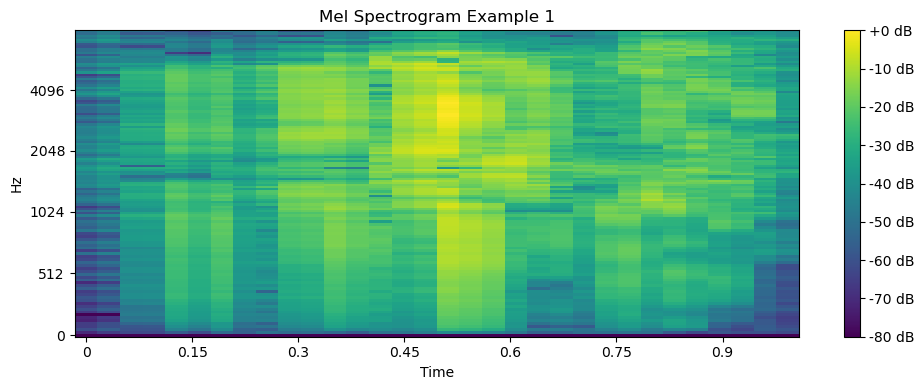

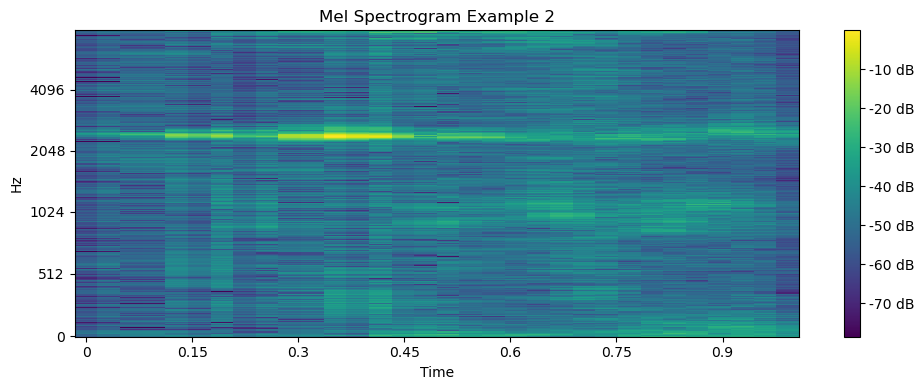

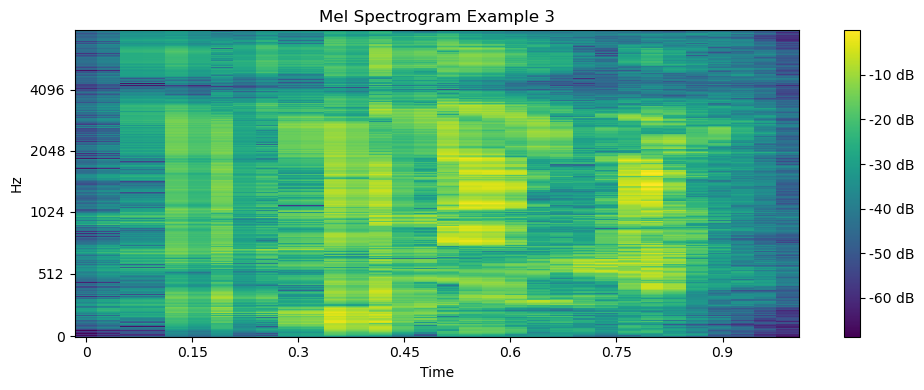

In [39]:
def plot_spectrogram(spectrogram, title="Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=16000, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot the first few spectrograms
for i in range(3):
    if i < len(features):
        plot_spectrogram(features[i], title=f"Mel Spectrogram Example {i+1}")
    else:
        break

In [40]:
print(f"Unique labels: {(set(labels))}")

# Convert labels to integers
mapped_labels = list(map(int, labels))

Unique labels: {0, 1}


In [66]:
class CryDataset(Dataset):
    def __init__(self, features, labels, max_len=8):
        self.features = features
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        if feature.shape[0] < self.max_len:
            pad_width = self.max_len - feature.shape[0]
            feature = np.pad(feature, ((0, pad_width), (0, 0)), mode='constant')
        else:
            feature = feature[:self.max_len, :]
        feature = torch.tensor(feature, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

# Instantiate the dataset
dataset = CryDataset(features, mapped_labels, max_len=8)


# Print dataset details
print(f"Total number of samples: {len(dataset)}")
print(f"Unique labels: {(set(labels))}")

Total number of samples: 3871
Unique labels: {0, 1}


In [80]:
# Split the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 3096
Test set size: 775


In [81]:
def collate_fn(batch):
    features, labels = zip(*batch)
    features = pad_sequence([torch.tensor(f, dtype=torch.float32) for f in features], batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return features, labels

# Create data loaders with the custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


# Print data loader details
print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in test set: {len(test_loader)}")
print(labels)

Number of batches in training set: 97
Number of batches in test set: 25
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 

In [82]:
import torch
import torch.nn as nn

class CryTransformer(nn.Module):
    def __init__(self, num_classes, input_dim=32, hidden_dim=128, num_heads=4, num_layers=2):
        super(CryTransformer, self).__init__()
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Project the input features to the hidden size expected by the transformer
        x = self.input_projection(x)
        # Transformer expects inputs of shape (sequence_length, batch_size, hidden_dim)
        x = x.permute(1, 0, 2)  # (batch_size, sequence_length, hidden_dim) -> (sequence_length, batch_size, hidden_dim)
        transformer_out = self.transformer_encoder(x)
        # Take the first token representation for classification
        out = transformer_out[0, :, :]
        out = self.fc(out)
        return out

# Example usage
num_classes = 2  # 0 for non-crying, 1 for crying
model = CryTransformer(num_classes, input_dim=32)


In [83]:
print(len(labels))

3871


In [87]:
def train_model(model, train_loader, num_epochs=4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

train_model(model, train_loader)

/tmp/ipykernel_3738406/2775333331.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = pad_sequence([torch.tensor(f, dtype=torch.float32) for f in features], batch_first=True)


Epoch 1/4, Loss: 0.23152721523470485
Epoch 2/4, Loss: 0.2105220245946314
Epoch 3/4, Loss: 0.20777494583240488
Epoch 4/4, Loss: 0.19794755071862458


In [88]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Specify the path where you want to save the model
model_save_path = 'cry_transformer_model.pth'

# Save the trained model
save_model(model, model_save_path)

Model saved to cry_transformer_model.pth


In [89]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(classification_report(all_labels, all_preds, target_names=['non-crying', 'crying']))


evaluate_model(model, test_loader)


/tmp/ipykernel_3738406/2775333331.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = pad_sequence([torch.tensor(f, dtype=torch.float32) for f in features], batch_first=True)


Accuracy: 90.71%
              precision    recall  f1-score   support

  non-crying       0.94      0.87      0.91       393
      crying       0.88      0.94      0.91       382

    accuracy                           0.91       775
   macro avg       0.91      0.91      0.91       775
weighted avg       0.91      0.91      0.91       775

